<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/data_processing/lessons/hid_hang_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sound and video processing

##Find bus passes from sound

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io.wavfile import read     # for read sound file

Let's upload first the sound track recorded at the middle of the bridge.

By reading the sound file, it is possible to get the length and the sample frequency.

In [ ]:
fs, snd_data = read('sample_data/bus11_22_24.mp3') # fs sample frequency
snd_data = snd_data / np.max(snd_data)            # normalize to -1 - +1 range
print(f'{snd_data.shape[0] / fs:.1f} seconds, {fs} Hz sound ')

1997.9 seconds, 48000 Hz sound 


Let's update the start time (14:49:50). Please note that time synchronization is very important for comparing the results of different methods.

In [ ]:
tstart = float(14 * 3600 + 49 * 60 + 50)                 # start time from midnight in seconds

Let's plot the wave form of the first 20 seconds of sound:

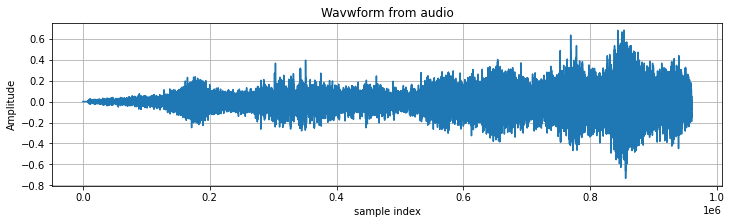

In [ ]:
fig=plt.figure(figsize=(12,3))
plt.plot(snd_data[:20 * fs])
plt.xlabel('sample index')
plt.ylabel('Amplitude')
plt.title('Waveform from audio')
plt.grid()

**RMS sound pressure calculation**

The larger is the sound wave oscillation, the more intense the sound will be. The intensity of a sound wave is proportional to the average over time of the square of its pressure PRMS.

$P_{RMS} = \sqrt{\frac{\sum_{dt} s_i^2} {n}}; dt = 0.1 sec;$

In [ ]:
wint = 0.1                                      # time window 0.1 s
wins = int(wint * fs)                           # time window width in index
n = snd_data.shape[0] // wins                   # number of time windows
p = snd_data[:wins * n].reshape((n, wins))      # change to 2D array
prms = np.sqrt(np.sum(np.square(p), axis=1) / wins)
tend = tstart + (prms.shape[0] -1) * wint       # end time in seconds from midnight
t = np.arange(tstart, tend, wint)

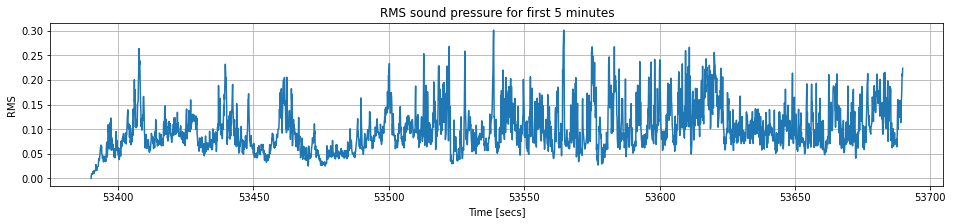

In [ ]:
plt.figure(2, figsize=(16,3))
plt.plot(t[:int(300 // wint)], prms[:int(300 // wint)])
plt.xlabel('Time [secs]')
plt.ylabel('RMS')
plt.title('RMS sound pressure for the first 5 minutes')
plt.grid()

Sound pressures are often given as relative pressures in units called decibels. The sound pressure is compared to a reference pressure.

$SPL = 20 log_{10} \frac{P_{RMS}} {P_{ref}}$

In [ ]:
pref = np.min(prms[3000:-3000])     # remove first and last 5 minutes from reference presure
spl = 20 * np.log10(prms / pref)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


To remove outliers, let's constrain our dataset to a time window of 1.1 sec.

$mSPL = min(SPL)_{dt}; dt = 1.1 sec$

Let's smooth the data with moving median to reduce the effects of outliers.

In [ ]:
win2t = 1.1                     # moving window of 1.1 seconds
win2s = int(win2t // wint)
m = (win2s - 1) // 2
mspl = np.zeros(n)
for i in range(m, n - m - 1):
    mspl[i] = np.median(spl[i - m: i + m])

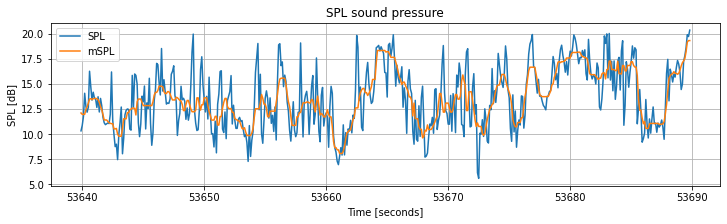

In [ ]:
l1 = int(250 // wint)
l2 = int(300 // wint)              # length of plot in seconds
plt.figure(3, figsize=(12,3))
plt.plot(t[l1:l2], spl[l1:l2], label="SPL")
plt.plot(t[l1:l2], mspl[l1:l2], label="mSPL")
plt.xlabel('Time [seconds]')
plt.ylabel('SPL [dB]')
plt.title('SPL sound pressure')
plt.grid()
plt.legend()

31 seconds above critical


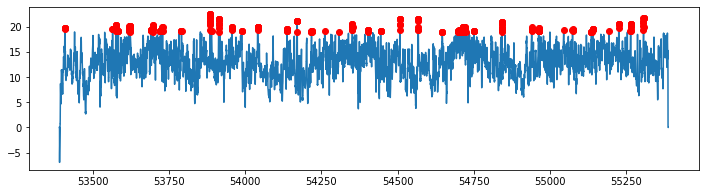

In [ ]:
critical = 19.0
snd = np.c_[t, mspl]
snd_bus = snd[snd[:,1] > critical]
print(f'{snd_bus.shape[0] * wint:.0f} seconds above critical')
plt.figure(4, figsize=(12,3))
plt.plot(t, mspl)
plt.plot(snd_bus[:,0], snd_bus[:,1], 'ro')

In [ ]:
start = 0                               # start row index of the first bus
sbus = []
for i in range(1, snd_bus.shape[0]):    # for each row except first
  if snd_bus[i,0] - snd_bus[i-1,0] > wint: # gap -> new bus arrived
    if snd_bus[i-1,0] - snd_bus[start,0] > 0.5:  # pass longer than 0.5 seconds?
      sbus.append((np.average(snd_bus[start:i,0]),
                  np.max(snd_bus[start:i,1]),
                  int(snd_bus[i-1,0] - snd_bus[start, 0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if snd_bus[-1,0] - snd_bus[start,0] > 0.5:
  sbus.append((np.average(snd_bus[start:,0]),
              np.max(snd_bus[start:,1]),
              int(snd_bus[-1,0] - snd_bus[start,0] + 0.5)))
print(f'{len(sbus)} busses found')
print(f'time   max.snd.  duration')
fo = open('sample_data/snd_bus.txt', 'w')
for b in sbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

20 busses found
time   max.snd.  duration
14:52:55  20.4     1
14:53:37  20.0     1
14:53:40  20.2     1
14:54:57  20.4     1
14:58:05  22.5     1
14:58:32  21.6     1
14:59:16  20.0     1
15:00:40  20.0     1
15:02:16  19.5     1
15:02:50  21.2     1
15:03:37  19.2     1
15:05:51  20.5     1
15:08:27  21.6     1
15:09:27  21.6     1
15:11:53  20.0     1
15:14:02  21.0     1
15:15:40  20.0     1
15:16:03  19.7     1
15:21:04  20.6     1
15:21:47  21.8     1


## Find bus passes from video record of bus lane

For this task, a recorded video of the bus lane at the middle of the bridge will be processed. For that, it will be used the OpenCV package.

In [ ]:
import cv2
!gdown --id 1wIFIpzRRm_lngAv74D1xMV1wc56_kocI -O sample_data/bridge_vid.mp4
!gdown --id 1P5Bq797ROdvCkIxdXCgHazfI01El2H8_ -O sample_data/empty_bridge.png
!gdown --id 1hiNd2P8q9hfwUYXeC8cYqLZM43PaytAZ -O sample_data/blue_bus.png

Downloading...
From: https://drive.google.com/uc?id=1wIFIpzRRm_lngAv74D1xMV1wc56_kocI
To: /content/sample_data/bridge_vid.mp4
100% 294M/294M [00:01<00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P5Bq797ROdvCkIxdXCgHazfI01El2H8_
To: /content/sample_data/empty_bridge.png
100% 559k/559k [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hiNd2P8q9hfwUYXeC8cYqLZM43PaytAZ
To: /content/sample_data/blue_bus.png
100% 213k/213k [00:00<00:00, 83.3MB/s]


Two sample images from the video are provided below:

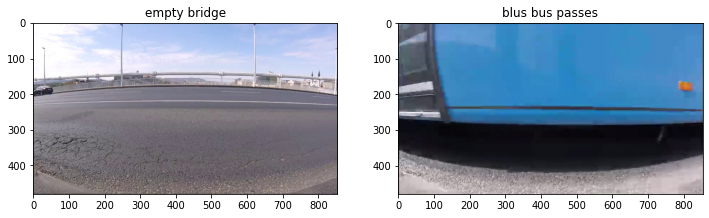

In [ ]:
img1 = cv2.imread('sample_data/empty_bridge.png')
img2 = cv2.imread('sample_data/blue_bus.png')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))            # use two subplots horizontaly
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.title.set_text('empty bridge')
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.title.set_text('blue bus passing')


What is the difference between the two images? How can we set up a criteria in a program to separate these two distinct situations?

Fist of all, we should use a small part of the image for analysis. For that, it will be considered **only** the closest lane; thus, let's cut the image verticaly between 230 and 270 pixels.

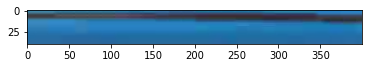

In [ ]:
plt.imshow(cv2.cvtColor(img2[230:270,200:600], cv2.COLOR_BGR2RGB))

As a very simple indicator value, let's use the average of pixels:

In [ ]:
low = 230
high = 270
left = 200
right = 600
indicator_empty = np.mean(img1[low:high, left:right])
indicator_bus = np.mean(img2[low:high, left:right])
print(f'Empty: {indicator_empty}, Bus: {indicator_bus}')

Emty: 123.200375, Bus: 100.75539583333334


Now, let's update the fps and start time:

In [ ]:
source = cv2.VideoCapture('sample_data/bridge_vid.mp4')
#fps = 30
fps = source.get(cv2.CAP_PROP_FPS)        # frame / seconds from video
print(f'video fps: {fps}')
act = tstart = 14 * 3600 + 49 * 60 + 50   # seconds from midnight
dt = 1 / fps                              # time step between frames (sec)

video fps: 29.970029531067727


In the next step, let's go through the different video frames, calculating the indicator values (it may take a few minutes...).

In [ ]:
video_data = []
while True:
  ret, frame = source.read()                    # read next frame
  if ret:
    val = np.mean(frame[low:high, left:right])  # calculate indicator
    video_data.append((act, val))
    act += dt
  else:
    break
source.release()

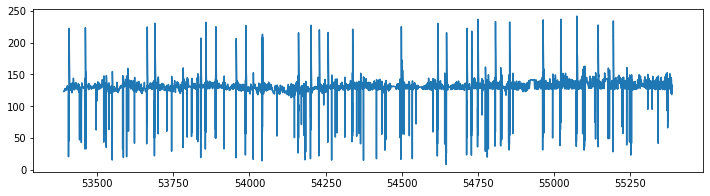

In [ ]:
vid_bus = np.array(video_data)
plt.figure(figsize=(12,3))
plt.plot(vid_bus[:,0], vid_bus[:,1])

In [ ]:
critical = 60
v_bus = vid_bus[vid_bus[:,1] < critical]
print(f'{v_bus.shape[0] / fps:.0f} seconds below critical')

25 seconds below critical


In [ ]:
start = 0                               # start row index of the first bus
vbus = []
for i in range(1, v_bus.shape[0]):    # for each row except first
  if v_bus[i,0] - v_bus[i-1,0] > 1:   # gap -> new bus arrived
    if v_bus[i-1,0] - v_bus[start,0] > 1: # pass longer than 1 seconds?
      vbus.append((np.average(v_bus[start:i,0]),
                  np.min(v_bus[start:i,1]),
                  int(v_bus[i-1,0] - v_bus[start,0] + 0.5)))           # store time, max deflection and duration (sec)
    start = i
# add last
if v_bus.shape[0] - start > 1:
  vbus.append((np.average(v_bus[start:,0]),
              np.max(v_bus[start:,1]),
              v_bus.shape[0]-start))
print(f'{len(vbus)} busses found')
print(f'time    max.soud duration')
print(f'hh:mm:ss  dB        sec')
fo = open('sample_data/vid_bus.txt', 'w')
for b in vbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

16 busses found
time    max.soud duration
hh:mm:ss  dB        sec
14:50:59  32.8     2
14:59:46  23.3     2
15:00:41  14.2     1
15:02:39  26.5     2
15:04:16  43.2     1
15:05:37  44.1     2
15:08:16  16.4     2
15:10:45   8.5     2
15:11:52  23.5     1
15:12:28  36.0     1
15:14:12  31.2     1
15:16:02  31.2     2
15:17:52  36.8     1
15:18:20  36.4     1
15:19:03  36.3     1
15:22:21  59.4     4


**Tasks**

*   How would the results change if you use different periods for PRMS calculation? What is a resonable value for time intervals?
*   Try to find better indicator values for video processing (what about comparing two subsequent images?)
*   Watch the recorded video and manualy record the passage of busses (ground truth values)
*   Try to improve the algorithms to get closer results to ground truth values
*   Make a decision logic using the results of the five different methods to make a better estimation for bus passes. Can you use machine learning algorithms for this purpose?

